In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


# from pandas_profiling import ProfileReport


In [2]:
df = pd.read_csv("FraudTransactions.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            809 non-null    object 
 1   amount          809 non-null    float64
 2   oldbalanceOrg   809 non-null    float64
 3   newbalanceOrig  809 non-null    float64
 4   oldbalanceDest  809 non-null    float64
 5   newbalanceDest  809 non-null    float64
 6   isFraud         809 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 44.4+ KB


In [4]:
df.columns

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud'],
      dtype='object')

In [5]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0
3,PAYMENT,7817.71,53860.0,46042.29,0.0,0.0,0
4,PAYMENT,7107.77,183195.0,176087.23,0.0,0.0,0


In [6]:
df.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,8.090000e+02,8.090000e+02,8.090000e+02,8.090000e+02,8.090000e+02,809.000000
mean,1.859497e+05,1.131419e+06,1.086634e+06,6.321314e+05,1.196135e+06,0.143387
std,6.430406e+05,2.331326e+06,2.322374e+06,2.004361e+06,3.487463e+06,0.350684
min,8.730000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,5.363000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,2.676850e+04,2.172900e+04,1.056300e+03,2.477700e+04,0.000000e+00,0.000000
75%,1.729867e+05,4.722832e+05,2.303378e+05,4.020634e+05,5.006317e+05,0.000000
max,1.000000e+07,1.290000e+07,9.987287e+06,1.700000e+07,1.920000e+07,1.000000


C:\Users\hamin\AppData\Local\Temp\ipykernel_36740\1879073672.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=False, bins=30)


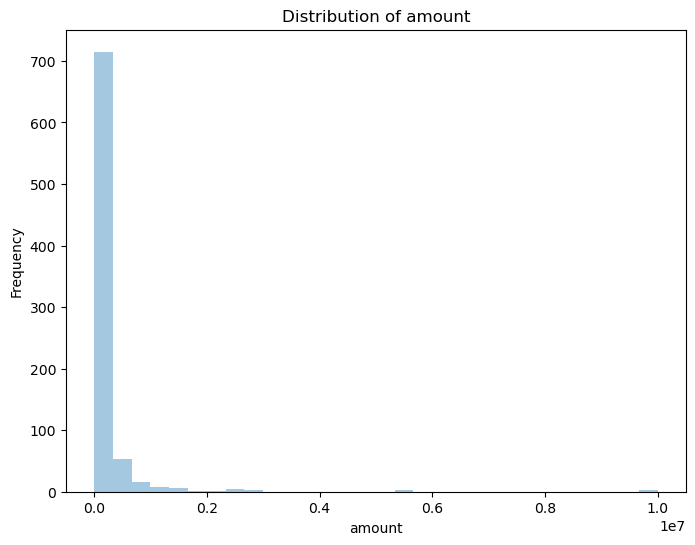

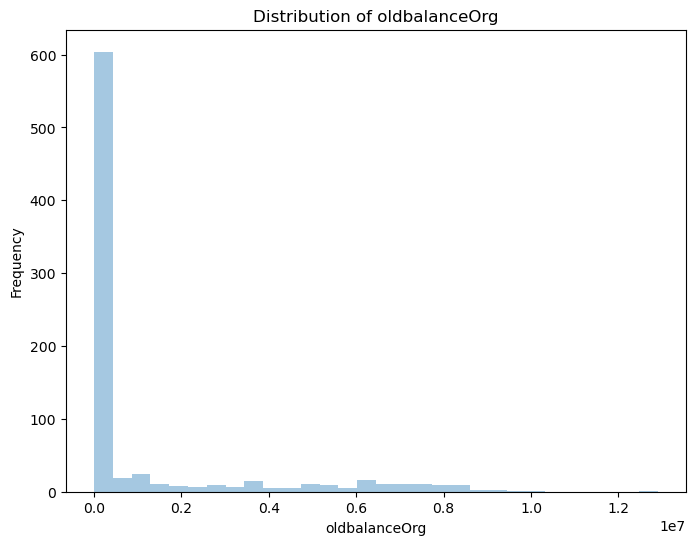

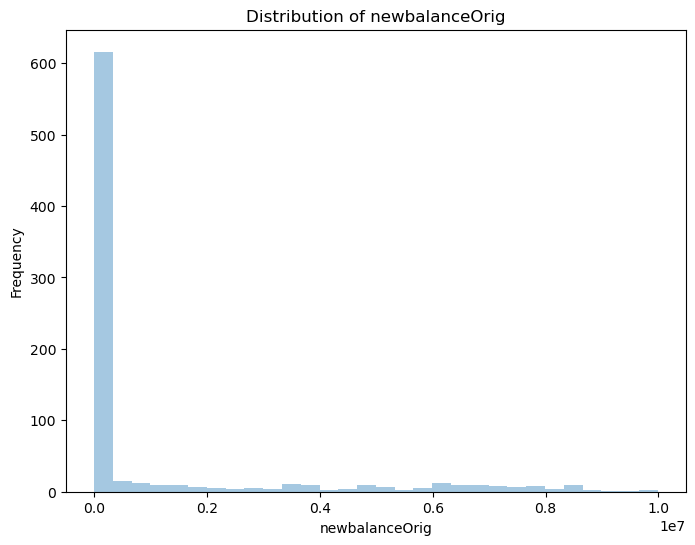

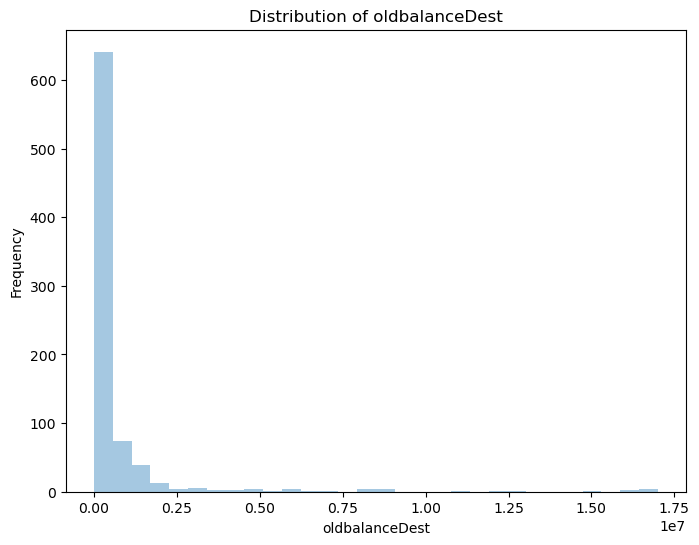

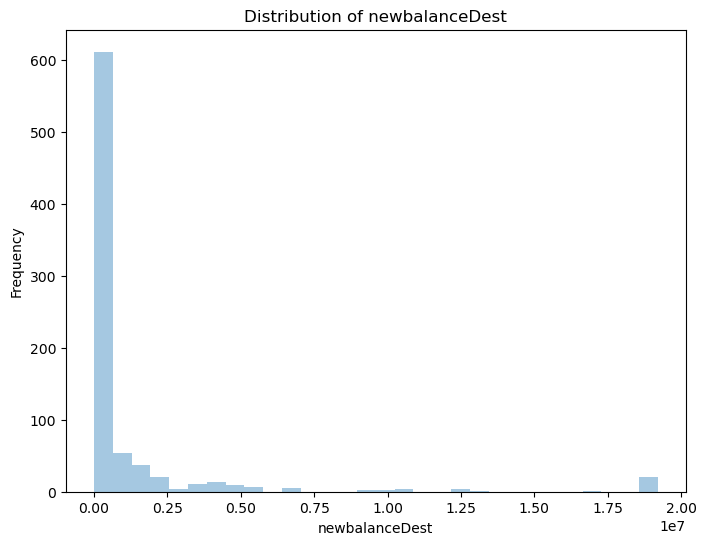

In [7]:
# Assuming df is your DataFrame
columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for column in columns:
    plt.figure(figsize=(8, 6))
    sns.distplot(df[column], kde=False, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

c:\Users\hamin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


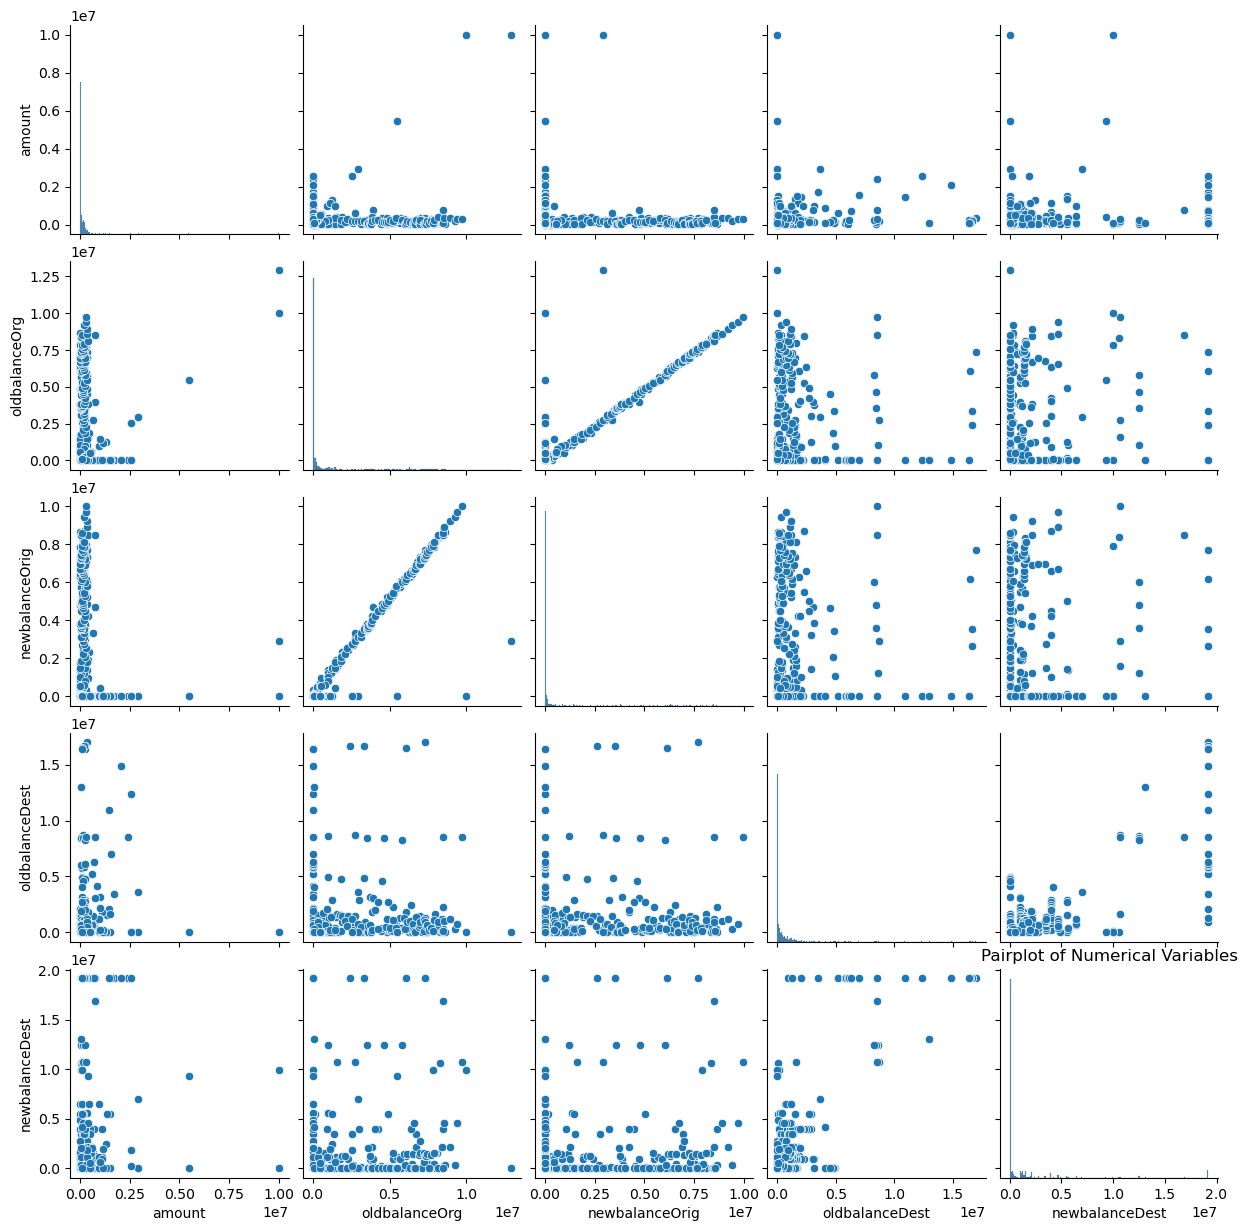

In [8]:
# Bivariate Analysis
sns.pairplot(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])
plt.title('Pairplot of Numerical Variables')
plt.show()

In [9]:
def remove_outliers_iqr(df):
    """
    Remove outliers from numerical columns in a DataFrame using the Interquartile Range (IQR) method.
    
    Parameters:
        df (DataFrame): Input DataFrame.
    
    Returns:
        DataFrame: DataFrame with outliers removed.
    """
    # Copy the input DataFrame to avoid modifying the original DataFrame
    df_cleaned = df.copy()
    
    # Counter to keep track of the number of data points removed
    num_removed = 0
    
    # Iterate over numerical columns
    for column in df_cleaned.select_dtypes(include='number').columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        q1 = df_cleaned[column].quantile(0.25)
        q3 = df_cleaned[column].quantile(0.75)
        
        # Calculate IQR (Interquartile Range)
        iqr = q3 - q1
        
        # Define the lower and upper bounds for outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Count outliers and replace with NaN
        outliers = (df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)
        num_removed += outliers.sum()
        df_cleaned.loc[outliers, column] = np.nan
    
    # Drop rows containing NaN values (outliers)
    df_cleaned = df_cleaned.dropna()
    
    # Print the number of data points removed
    print(f"Number of data points removed: {num_removed}")
    
    return df_cleaned


In [17]:
def build_classification_model(data, target_column, model_choice):
    """
    Build a classification model based on the user's choice of model and print out the top 3 important features.
    
    Parameters:
        data (DataFrame): The input DataFrame.
        target_column (str): The name of the target column.
        model_choice (str): The chosen classification model 
                            ('Random Forest', 'Decision Tree', 'Logistic Regression', 'SVM', 'Naive Bayes', or 'XGBoost').
    
    Returns:
        dict: A dictionary containing train score, test score, confusion matrix, and predictions.
    """
    # Extract features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the chosen classification model
    if model_choice == 'Random Forest':
        model = RandomForestClassifier()
    elif model_choice == 'Decision Tree':
        model = DecisionTreeClassifier()
    elif model_choice == 'Logistic Regression':
        model = LogisticRegression()
    elif model_choice == 'SVM':
        model = SVC()
    elif model_choice == 'Naive Bayes':
        model = GaussianNB()
    elif model_choice == 'XGBoost':
        model = XGBClassifier()
    elif model_choice == 'KNN':
        model = KNeighborsClassifier()
    elif model_choice == 'AdaBoost':
        model = AdaBoostClassifier()
    elif model_choice == 'Gradient Boosting':
        model = GradientBoostingClassifier()
    elif model_choice == 'Neural Network':
        model = MLPClassifier()
    else:
        raise ValueError("Invalid model choice. Choose from 'Random Forest', 'Decision Tree', 'Logistic Regression', 'SVM', 'Naive Bayes', 'XGBoost', 'KNN', 'AdaBoost', 'Gradient Boosting', or 'Neural Network'.")
   
    # Train the model
    model.fit(X_train, y_train)
    
    # Get feature importance (if applicable)
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        if len(feature_importance) >= 3:
            top_features_idx = np.argsort(feature_importance)[::-1][:3]
            top_features = X.columns[top_features_idx]
            print(f"Top 3 important features affecting {target_column}:")
            for i, feature in enumerate(top_features):
                print(f"{i+1}. {feature}")
        else:
            print("Feature importance is not available for this model.")
    else:
        print("Feature importance is not available for this model.")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate train and test scores
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Create dictionary to store results
    results = {
        'train_score': train_score,
        'test_score': test_score,
        'confusion_matrix': conf_matrix,
        'predictions': y_pred
    }
    
    return results

In [18]:
def create_dummy_data(data):
    """
    Generate dummy data for all categorical columns in the DataFrame.
    
    Parameters:
        data (DataFrame): The input DataFrame.
    
    Returns:
        DataFrame: A new DataFrame with dummy variables for all categorical columns.
    """
    # Get list of categorical columns
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    # Create dummy variables for categorical columns
    dummy_data = pd.get_dummies(data, columns=categorical_columns)
    
    return dummy_data

In [12]:
df = create_dummy_data(df)

In [19]:
results = build_classification_model(df, "isFraud", "Logistic Regression")
print("Train Score:", results['train_score'])
print("Test Score:", results['test_score'])
print("Confusion Matrix:")
print(results['confusion_matrix'])
print("Predictions:")
print(results['predictions'])

Feature importance is not available for this model.
Train Score: 0.9335394126738794
Test Score: 0.9444444444444444
Confusion Matrix:
[[131   7]
 [  2  22]]
Predictions:
[1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 1 0 0 0 0 1 1 0]


In [20]:
results = build_classification_model(df, "isFraud", "Random Forest")
print("Train Score:", results['train_score'])
print("Test Score:", results['test_score'])
print("Confusion Matrix:")
print(results['confusion_matrix'])
print("Predictions:")
print(results['predictions'])

Top 3 important features affecting isFraud:
1. oldbalanceDest
2. oldbalanceOrg
3. amount
Train Score: 1.0
Test Score: 0.9876543209876543
Confusion Matrix:
[[137   1]
 [  1  23]]
Predictions:
[1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 1 1 0]
